# Análise de Dados

#### 1 - Lendo as bases de dados
Unificando as bases de dados para termos todas as informações em um único arquivo.

In [2]:
import pandas as pd
import glob

# Caminho onde os arquivos CSV estão armazenados
# Ajuste o caminho conforme necessário
caminho_dos_arquivos = 'PSEL Data Science 2024/*.csv'

# Lista todos os arquivos CSV no diretório
arquivos_csv = glob.glob(caminho_dos_arquivos)

# Lista para armazenar os DataFrames
lista_dfs = []

# Loop para ler e adicionar cada arquivo à lista
for arquivo in arquivos_csv:
    df = pd.read_csv(arquivo)
    lista_dfs.append(df)

# Concatenar todos os DataFrames em um único DataFrame
dados_unificados = pd.concat(lista_dfs, ignore_index=True)

# Exibir as primeiras linhas dos dados unificados para verificar
print(dados_unificados.head())

# Salvar o DataFrame unificado em um novo arquivo CSV
dados_unificados.to_csv('dados_unificados.csv', index=False)


    ano        uf     genero        mes  numero
0  2019  Rondônia  Masculino    Janeiro       0
1  2019  Rondônia  Masculino  Fevereiro       4
2  2019  Rondônia  Masculino      Março       1
3  2019  Rondônia  Masculino      Abril       0
4  2019  Rondônia  Masculino       Maio       0


#### 2 - ETL
Precisamos fazer todo o processo de extração, limpeza e trataemnto do dados.

In [3]:
import pandas as pd

# Carregar o arquivo CSV
arquivo_csv = 'dados_unificados.csv'
dados = pd.read_csv(arquivo_csv)

# Mostrar as primeiras linhas
print(dados.head())


    ano        uf     genero        mes  numero
0  2019  Rondônia  Masculino    Janeiro       0
1  2019  Rondônia  Masculino  Fevereiro       4
2  2019  Rondônia  Masculino      Março       1
3  2019  Rondônia  Masculino      Abril       0
4  2019  Rondônia  Masculino       Maio       0


In [7]:
# Verificar informações gerais e tipos de dados
print(dados.info())

# Verificar estatísticas descritivas
print(dados.describe())

# Verificar valores ausentes
print(dados.isnull().sum()) #sem valores ausentes para tratar



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4536 entries, 0 to 4535
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ano     4536 non-null   int64 
 1   uf      4536 non-null   object
 2   genero  4536 non-null   object
 3   mes     4536 non-null   object
 4   numero  4536 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 177.3+ KB
None
              ano       numero
count  4536.00000  4536.000000
mean   2018.00000    11.257937
std       2.00022    27.886390
min    2015.00000     0.000000
25%    2016.00000     1.000000
50%    2018.00000     4.000000
75%    2020.00000    11.000000
max    2021.00000   827.000000
ano       0
uf        0
genero    0
mes       0
numero    0
dtype: int64


#### 3 - Fazendo a previsão dos próximos 2 anos para casamentos homoafetivos

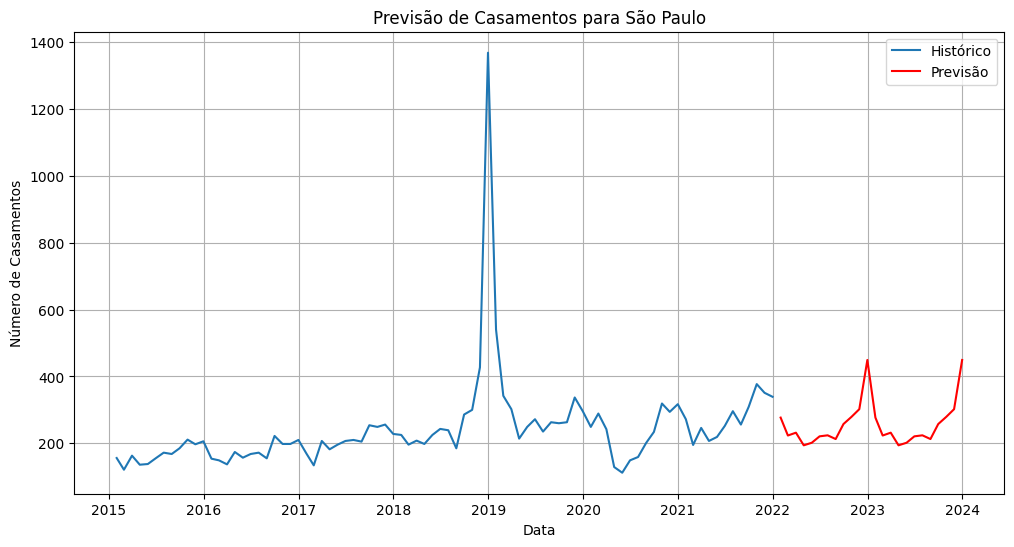

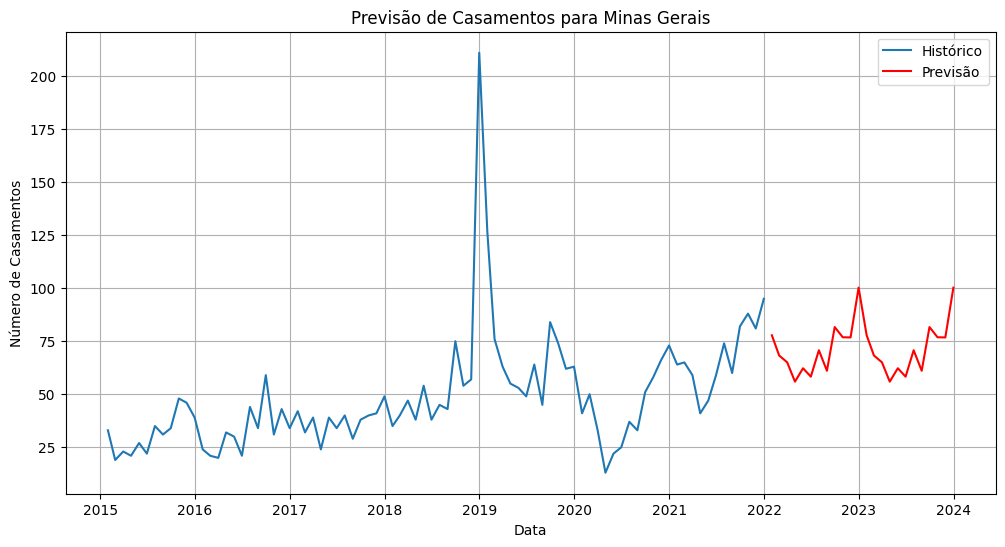

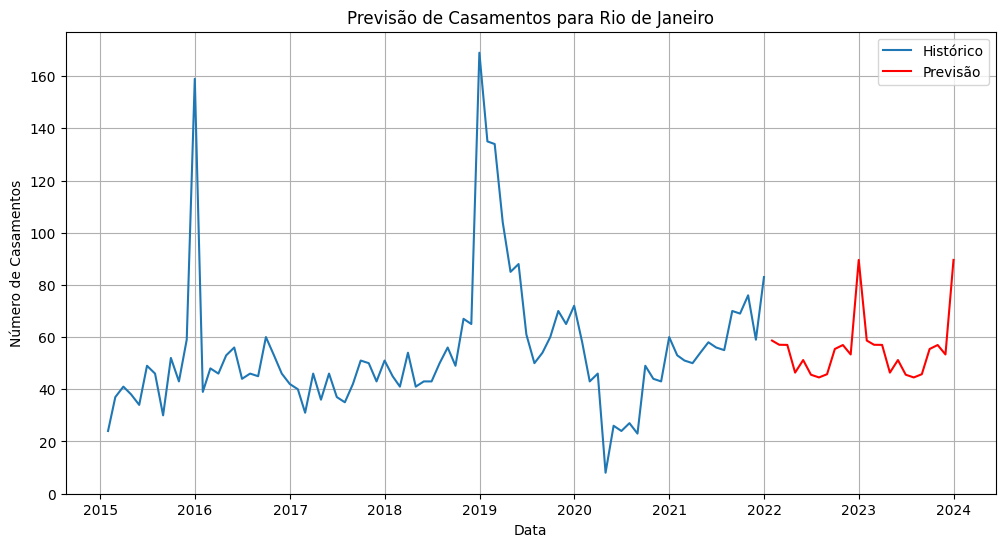


Previsão para São Paulo:
2022-01-31    276.847962
2022-02-28    223.287888
2022-03-31    231.748551
2022-04-30    193.944645
2022-05-31    201.617696
2022-06-30    220.782603
2022-07-31    223.859622
2022-08-31    212.703876
2022-09-30    257.590314
2022-10-31    279.151071
2022-11-30    302.050424
2022-12-31    449.137725
2023-01-31    276.847962
2023-02-28    223.287888
2023-03-31    231.748551
2023-04-30    193.944645
2023-05-31    201.617696
2023-06-30    220.782603
2023-07-31    223.859622
2023-08-31    212.703876
2023-09-30    257.590314
2023-10-31    279.151071
2023-11-30    302.050424
2023-12-31    449.137725
Freq: M, dtype: float64

Previsão para Minas Gerais:
2022-01-31     77.791786
2022-02-28     68.266225
2022-03-31     65.029948
2022-04-30     55.931065
2022-05-31     62.256872
2022-06-30     58.284428
2022-07-31     70.739184
2022-08-31     61.064020
2022-09-30     81.668316
2022-10-31     76.852991
2022-11-30     76.779755
2022-12-31    100.256825
2023-01-31     77.791

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Carregar dados
dados = pd.read_csv('dados_unificados.csv')

# Mapear nomes dos meses para números
meses_map = {
    'Janeiro': 1, 'Fevereiro': 2, 'Março': 3, 'Abril': 4, 'Maio': 5, 'Junho': 6,
    'Julho': 7, 'Agosto': 8, 'Setembro': 9, 'Outubro': 10, 'Novembro': 11, 'Dezembro': 12
}
dados['mes'] = dados['mes'].map(meses_map)

# Criar coluna de data a partir das colunas ano e mes
dados['data'] = pd.to_datetime(dados['ano'].astype(str) + '-' + dados['mes'].astype(str) + '-01', format='%Y-%m-%d')

# Filtrar para os 3 estados com maior número de casamentos no último ano
ultimo_ano = dados['ano'].max()
dados_ultimo_ano = dados[dados['ano'] == ultimo_ano]
top_3_estados = dados_ultimo_ano.groupby('uf')['numero'].sum().nlargest(3).reset_index()

# Filtro para os 3 estados com maior número de casamentos
dados_top_3 = dados[dados['uf'].isin(top_3_estados['uf'])]

# Preparar dados para previsão
predicoes = {}
for estado in top_3_estados['uf']:
    dados_estado = dados_top_3[dados_top_3['uf'] == estado]
    dados_estado = dados_estado.set_index('data')
    dados_estado = dados_estado.resample('M').sum()  # Agregar por mês

    # Modelo de suavização exponencial
    modelo = ExponentialSmoothing(dados_estado['numero'], seasonal='add', seasonal_periods=12)
    ajuste = modelo.fit()
    previsao = ajuste.forecast(steps=24)  # Previsão para os próximos 24 meses

    predicoes[estado] = previsao

    # Visualização da previsão
    plt.figure(figsize=(12, 6))
    plt.plot(dados_estado.index, dados_estado['numero'], label='Histórico')
    plt.plot(previsao.index, previsao, label='Previsão', color='red')
    plt.title(f'Previsão de Casamentos para {estado}')
    plt.xlabel('Data')
    plt.ylabel('Número de Casamentos')
    plt.legend()
    plt.grid(True)
    plt.show()

# Mostrar previsões
for estado, previsao in predicoes.items():
    print(f'\nPrevisão para {estado}:')
    print(previsao)


Considerando essas previsões de casamentos homoafetivos nos próximos 2 anos, podemos concluir que o número tende a crescer, mas crecserá mais para o estado de SP.

O código acima utiliza o modelo de suavização exponencial para prever o número de casamentos nos três estados com mais casamentos. Essa técnica é adequada para séries temporais com sazonalidade clara. É importante garantir que os dados estejam bem preparados e que o modelo escolhido seja apropriado para a natureza dos dados. A visualização ajuda a comunicar os resultados, mas deve ser complementada com análise detalhada.

#### 4 - Aplicando testes de hipótese e correlação estatística etre as variáveis

Teste t de Student: Estatística = -2.26, p-valor = 0.0494
Correlação entre o número de casamentos e o ano: 0.66


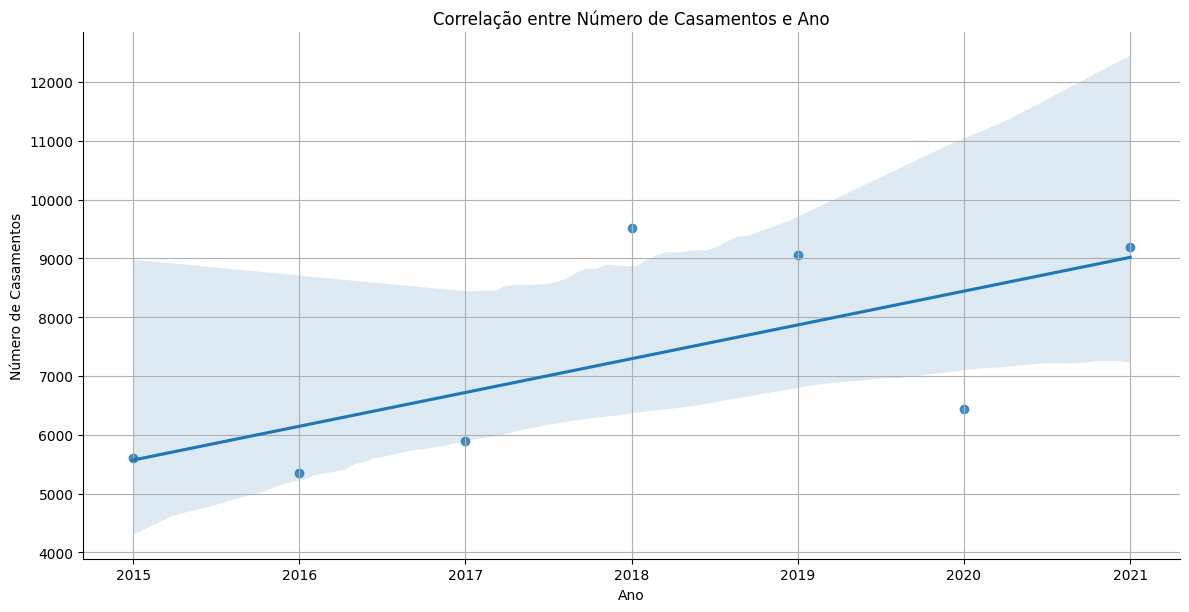

                            OLS Regression Results                            
Dep. Variable:                 numero   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     3.932
Date:                Mon, 16 Sep 2024   Prob (F-statistic):              0.104
Time:                        23:51:38   Log-Likelihood:                -60.103
No. Observations:                   7   AIC:                             124.2
Df Residuals:                       5   BIC:                             124.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.152e+06   5.85e+05     -1.970      0.1

c:\Users\laiza\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [19]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar dados
dados = pd.read_csv('dados_unificados.csv')

# Convertendo o mês para número
meses_map = {
    'Janeiro': 1, 'Fevereiro': 2, 'Março': 3, 'Abril': 4, 'Maio': 5, 'Junho': 6,
    'Julho': 7, 'Agosto': 8, 'Setembro': 9, 'Outubro': 10, 'Novembro': 11, 'Dezembro': 12
}
dados['mes'] = dados['mes'].map(meses_map)
dados['data'] = pd.to_datetime(dados['ano'].astype(str) + '-' + dados['mes'].astype(str) + '-01', format='%Y-%m-%d')

# 1. Teste de Hipóteses: Diferença entre gêneros
# Agrupando dados por gênero e ano para calcular o total de casamentos
dados_genero = dados.groupby(['ano', 'genero'])['numero'].sum().reset_index()

# Teste t de Student para verificar se há diferença significativa entre gêneros
genero_1 = dados_genero[dados_genero['genero'] == 'Masculino']['numero']
genero_2 = dados_genero[dados_genero['genero'] == 'Feminino']['numero']

t_stat, p_value = stats.ttest_ind(genero_1, genero_2, equal_var=False)
print(f'Teste t de Student: Estatística = {t_stat:.2f}, p-valor = {p_value:.4f}')

# 2. Correlação entre número de casamentos e ano
# Criar um dataframe para análise de correlação
dados_correlacao = dados.groupby(['ano'])['numero'].sum().reset_index()

# Cálculo da correlação
correlacao = dados_correlacao['ano'].corr(dados_correlacao['numero'])
print(f'Correlação entre o número de casamentos e o ano: {correlacao:.2f}')

# Visualização da correlação
sns.lmplot(x='ano', y='numero', data=dados_correlacao, aspect=2, height=6)
plt.title('Correlação entre Número de Casamentos e Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Casamentos')
plt.grid(True)
plt.show()

# Verificar a relação entre a variável dependente 'numero' e a variável independente 'ano' com uma regressão linear
X = sm.add_constant(dados_correlacao['ano'])  # Adiciona constante para o intercepto
model = sm.OLS(dados_correlacao['numero'], X).fit()
print(model.summary())


Concluindo:
Existe uma diferença estatisticamente significativa no número de casamentos entre os gêneros Masculino e Feminino.ALém disos, sobre tendência temporal, há uma correlação positiva significativa entre o número de casamentos e o ano, indicando um aumento no número de casamentos ao longo do tempo.

Nota-se também um R-squared (R²) de 0.440, ou seja, aproximadamente 44% da variabilidade no número de casamentos é explicada pela variável independente (ano). Isso sugere que o modelo explica uma parte significativa da variabilidade, mas há outras variáveis que também influenciam o número de casamentos.  O R² ajustado é menor que o R², o que é comum em modelos com poucas observações, pois penaliza a inclusão de variáveis independentes adicionais que não contribuem significativamente para o modelo.

Analisando os resultados podemos notar possíveis problemas potenciais, como há indícios de problemas de multicolinearidade ou problemas numéricos, o que pode afetar a confiabilidade das estimativas do modelo.